# Introducing Recurrent Neural Networks with Long-Short-Term Memory and Gated Recurrent Unit to predict reported Crime Incidents

<img align="right" src="pics/crime_intro.png" alt="NN" style="width: 500px;"/>
Several police departments across the Unites States have been experimenting with software for crime prdiction. This  started a controversial debate: Critics are questioning the predictiv power of the underlying machine learning models and point out biases towards certain crime typs and neighborhoods. We took this as occacion to look into the publicly available <a href="https://catalog.data.gov/dataset/crimes-2001-to-present-398a4">crime records of the city of chicago</a>. The data set contains close to 7 milliom reported crime incidences starting from 2001 until the precceding week of the data download. It includes 22 columns with detailed information, such as type of the offence,  geo location,  district and the time of crime occurence. We will focus on temporal patterns in the data by predicting crime frequencies per day on the district level. Such a model may be used in practice to faciliate personel planning across the districts for the chigaco police force. We generate the input data for model building by counting the reported crimes by day and district. This results in a table with three columns containing date, district and the respective counts. 




In [1]:
import pandas as pd

data = pd.read_csv('../data/crimes_district.csv')
data.head()

,District,Date,Incidents
0,1.0,2001-01-01,37.0
1,1.0,2001-01-02,44.0
2,1.0,2001-01-03,44.0
3,1.0,2001-01-04,41.0
4,1.0,2001-01-05,67.0


By changing this aggregation on the time or the locational level a similar model for more granular predictions might be build. This is under the assumption of enough representative data on a more detailed aggregation level. We will take the described use case as an example to introduce Recurrent Neural Networks (RNNs) with Long-Short-Term memory (LSTM) and Gated Recurrent Unit (GRU). First we explain the general concept behind RNNs and train a simple network using different input formats. We then introduce RNNs with LSTM and GRU to overcome the vanishing gradient problem. After explaining the forward pass and the derivation of LSTM and GRU we tune the hyperparameters for the three introduced RNN variants and compare their performance.

## Introduction to Recurrent Neural Networks

Many machine learning tasks are based on the assumption of identically independent distributed (i.i.d.) samples. Thus a prediction for a label $y_i$ only depends on the corresponding feature vector $\vec{x_i}$, where $i$ denotes the index of the sample. When working with sequential data, one typically wants to predict a future outcome $\vec{y_{t+1}}$, which often equals the following observable vector $\vec{x_{t+1}}$, from a sequence of previously observed vectors $\vec{x_t}$, …, $\vec{x_{t-T}}$. $t$ denotes the last observed point of time and $T$  the number of observations since the start of the sequence.
While the vectors within a sequence are assumed to be dependent, we might still work with multiple mutually independent time series in a dataset. In this case one could use de notation $\vec{x_{ti}}$, corresponding to the observed vector at time $t$ from the sample sequence $i$. For simplicity we omit the sample index below. Note that many sequential prediction tasks are based on one dimensional time series, in that case one may also omit the vector notation. However, we stick to the more general form. <br>
A simple feedforward network may be used to make predictions under the i.i.d assumption by passing one feature vector $\vec{x_i}$ at a time through the network. However, if one wants to account for temporal dependencies between the observed vectors $\vec{x_t}$, …, $\vec{x_{t-T}}$ the network needs some kind of memory. That’s the concept behind recurrent neural networks: They use hidden activations, referred to as hidden state, to carry information within the network from one observation to the following one.


<img align="center" src="pics/RNN_t2.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'>Image 1: Recurrent Neural Network with a sequence length of two.</p>

Image 1 illustrates how a simple RNN may be used to predict $\vec{y_{t+1}} (:= \vec{x_{t+1})} $ given a sequence of two observed vectors $\vec{x_t}$ and $\vec{x_{t-1}}$. The rectangles represent the input vectors. Each circle represents a vector of hidden activations and the triangle represents the output i.e. the predicted label. The arrows illustrate layer operations, i.e. the multiplication of the previous vector with one of the weight matrices $W_{in}$, $W_h$, or $W_{out}$, denoted by different colours. To make a prediction for $\vec{y_{t+1}}$, the first vector in the sequence $\vec{x_{t-1}}$ gets multiplied with the input weights $W_{in}$ and the activation function is applied to produce the first hidden state $\vec{h_{t-1}}$. Since $\vec{x_{t-1}}$ is the first observation in the sequence, $\vec{h_{t-1}}$ represents all available information at the time step $t-1$. To carry this information to the next hidden state $\vec{h_t}$, $\vec{h_{t-1}}$ gets multiplied with the hidden weight matrix $W_h$. Consecutively the new input $\vec{x_t}$ is multiplied with the input matrix $W_{in}$. The resulting vector carries the new information extracted from $\vec{x_t}$. This newly available information needs to be combined with the knowledge about previous observations to create $\vec{h_t}$. This can be done by summing up the two outputs from the matrix products and the bias $b_h$ and applying the  hyperbolic tangents as activation function to the vector sum (Equation 1). This is illustrated by the intersect of the green and the orange arrow. Conceptually the weights in $W_h$ represent the importance of previous observations and the weights in $W_{in}$ represent the importance of new information for the prediction task.
All available information at the time step $t$ is now aggregated in $\vec{h_t}$. To make a prediction for $\vec{y_{t+1}}$ it gets multiplied with the output weight matrix $W_{out}$ (Eqation 2). The size of $W_{out}$ and the corresponding activation function are, as usually, defined by the prediction task (regression or classification). This steps cover the forward pass in a simple RNN.
<br>
<br>
$\vec{h_t} = tanh(W_{in} * \vec{h_{t-1}} +  \vec{x_{t}} +\vec{b_{h}} )$  (Eqation 1)
<br>
$\vec{y_{t+1}} = ReLu(W_{out} * \vec{h_t} + \vec{b_{out}} )$ (Eqation 2)
<br>
<br>
If we want to look back more time steps when making a prediction for $\vec{y_{t+1}}$, we just need to add another hidden state and another input for every additional time step. Image 3 illustrates how this may look for a sequence of length three. Interestingly, even though RNNs can get quite deep along the time dimension, they have relatively few parameters. This is the case because all inputs or hidden states represent the same thing, another time step in the series or another aggregation of past observations. Thus, we only have to train three different weight matrices, one for the input, one for the hidden state and one for the output.<br>

<img  src="pics/RNN_t3.png" alt="NN" style="width: 550px;"/>
<p style='text-align: center;'>Image 2: Recurrent neural network with a sequence length of three.</p>

Drawing RNNs with more time steps becomes cumbersome. We have to keep adding inputs and hidden states. The same holds true if we would like to construct them in in python. A more elegant and flexible representation is given in Image 4. Compared to Image 3 the repetitive elements have been put into a loop. For every time step in the sequence length $T$, the new input is feed into the network and combined with the previous hidden state. The new hidden state is passed back to the start of the loop as input to the next iteration. The loop stops at the end of the sequence and the last hidden state is put through the output layer. To include the first timestep within the loop representation, an initial hidden state $\vec{h_0}$ is defined as a vector of zeros.


<img  src="pics/RNN_Loop.png" alt="NN" style="width: 350px;"/>
<p style='text-align: center;'>Image 3: Recurrent neural network with a loop and a sequence length of $T$.</p>


Keras provides a predefined model layer that constructs the described RNN behind the scenes. However, to emphasise the described operations, we demonstrate how to construct it by yourself using fully connected layers and the keras functional API. In keras a layer refers to a set of layer operations, typically a matrix multiplication and the application of an activation function, that output a new vector of activations. We follow this notation below.<br>
The functional  API allows to define a list of inputs and put them through several layers to produce a (list of) output(s). It then connects inputs and output(s) so the keras backend can be used to derive the gradients and train the model. We start implementing the RNN by initializing the `input_list`. The basic properties of a simple RNN are defined by the number of the hidden activations `H_SZ` , the sequence length `SEQ_LEN` and the number of features `FEAT_SZ` per time step. By choosing `H_SZ`, the shape of the three weight matrices is sufficiently defined: The second and first dimension of $W_{in}$ and $W_{out}$ are respectively defined by the shape of the input data and the labels. Moreover, the first dimension of $W_{in}$ must match the first dimension of $W_h$, so their outputs can be added together. $W_h$ must be squared because the result of the matrix product $W_h$ x $h_t$ gets again multiplied with $W_h$. Since $h_t$ gets also multiplied by $W_{out}$ the second dimension of $W_{out}$ must also be `H_SZ`. We set `H_SZ` to five and `SEQ_LEN` to ten after little manual tuning. In general, the parameters did not seem to have a great impact on the model performance. Since the crime data consists of one-dimensional time series `FEAT_SZ` is given as one.

In [2]:
import keras.backend as K
from keras import metrics

from keras.layers import Input, Dense, add, Activation, SimpleRNN, TimeDistributed
from keras.models import Model, Sequential


# create list to keep track of inputs
input_list = []

# initialize RNN properties
H_SZ = 5
SEQ_LEN = 10
FEAT_SZ = 1

Using TensorFlow backend.


The `Dense()` layer in keras holds the weights of a fully connected layer. It is initialized by passing the output dimension to the `Dense()` class. The input dimension will be interfered from the first input. After initialization, it can be called on a tensor which will return the resulting output activations. The three layers of the network are initialized by passing the respective number of output activations `H_SZ`, `H_SZ` and `FEAT_SZ` to the `Dense()` class.

In [3]:
# initilize fully connected layers and the activation function of the hidden state
first_layer = Dense(H_SZ, name = 'first_layer')
hidden_layer = Dense(H_SZ , name = 'hidden_layer')
tanh = Activation('tanh')
output_layer = Dense(FEAT_SZ, activation='relu', name = 'output_layer')

We  loop through the sequence length and create for every time step a new input `x` and append it to the input list. The input activations `act_in` are calculated for every time step by putting the input variable `x` through the first layer. We additionally initialize `h0` as a vector of zeros with the same (variable) shape as the input activations at the first time step. The new hidden state `ht` gets updated implementing Equation 1. After the loop the final hidden state is put through the output layer to make a prediction. Finally the functional API `Model()` connects input and output variables to create `myRNN`. Since keras typically works with tensors a function that splits a three-dimensional tensor along the second dimension, which corresponds to time dimension in keras, is defined.

In [4]:
for i in range(SEQ_LEN):
  
  # get input vector and append it to input list
  x = Input(shape = (FEAT_SZ,))
  input_list.append(x)
  
  # calculate input actiavtions
  act_in = first_layer(x)
  
  if(i == 0):
  # initialize h0 with zeros and append it to input list
    h0 = K.zeros_like(act_in)
    input_list.append(h0)  
    ht = Input(tensor = h0, name = 'h0')
  
  # calculate hidden activations
  ht = tanh(add([hidden_layer(ht), act_in])) 
  
# calculate output
out = output_layer(ht)

myRNN = Model(inputs=input_list, outputs=out)

In [5]:
def get_input(X):
  # slice 3-dim tensor along 2nd axis into list of inputs
  return([X[:,i,:] for i in range(X.shape[1])])

### Formatting sequential data

We load the reported crimes, counte by district and day and change the long-format in wide-format to get a matrix of 24 districts by 6513 timsteps.
By training one model on the time series from all districts, we assume each series to be a different realization of the same underlying sequential pattern. An obvious alternative would be to train a separate model for each district. 
Before further formatting we split the data into a train and a validation set. The validation set should resemble the data, the model would see in production. We therefore use the data from 2015 - 2017 as validation set. We will later use the most resent crime counts from 2017 as test set.
One can not simply train a neural network on 24 long time series.
It is common practice to split long time series into sub-sequences, treating them as independent samples. The simplest way to do this is, to slide a window of length `SEQ_LEN` through each series and treat each subseries contained in the window as one sample. The direct successor after the window defines the respective label for the sub-series (Image 4). 
Note that we will use the terms sample sequence and sub-sequence to a certain degree interchangable. Sample is used refering to the sequential counts in a row of the data matrix used for model training. Sub-sequence also refers to such a row, but it shall emphasis the row beeing a sub-sequence of a longer time series over the whole observation period.
<img align="center" src="pics/Format1.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'>Image 4: Formatting data input for recurrent neural networks.</p>


In [6]:
full_seqs = data.pivot(index='District', columns='Date', values='Incidents')

In [7]:
dates = pd.to_datetime(full_seqs.columns)

lower = pd.to_datetime("2015-01-01")
upper = pd.to_datetime("2017-01-01")
end = pd.to_datetime("2018-01-01")

In [8]:
tr_idx = full_seqs.columns[dates < lower]
val_idx = full_seqs.columns[(dates >=lower) == (dates < upper)]

full_seqs_tr = full_seqs[tr_idx].values
full_seqs_val = full_seqs[val_idx].values

full_seqs_tr.shape, full_seqs_val.shape

((24, 5113), (24, 731))

We implement the sliding window by looping through the 24 full sequences and use array slicing withn a list comprehension to create the sub-sequences. The resulting sub-sequences are stacked vertically. Recurrent layers in keras and `MyRNN` above expect an input tensor of the dimensions `[batch_size, timesteps, input_dim]`. Since we work with one dimensional series, we have ignored the third dimension so far. In order to match the required input shape a thrid dimension of size one is added to the array.

In [9]:
def cut_sequences(long_seqs, SEQ_LEN):
  # input matrix of long sequences [sequences, timesteps]
  # returns matrix of subsequences X [subsequences, SEQ_LEN, 1], and labels y[subsequences,1]
  X = []
  y = []

  for long_seq in long_seqs:
    n = long_seq.shape[0]
    # slide window of SEQ_LEN over full sequence
    seq_stacked = np.stack([long_seq[i:i+SEQ_LEN] for i in range(n-SEQ_LEN)])
    labels = np.array([long_seq[i] for i in np.arange(SEQ_LEN, n)]).reshape(-1,1)
    X.append(seq_stacked)
    y.append(labels)

  X =  np.vstack(X)
  #add axis for number of features per time step = 1  
  X = X[:,:,np.newaxis]
  y =  np.vstack(y)
  
  return(X,y)

In [10]:
import numpy as np

# cut sequences in sub sequences of length SEQ_LEN
X_tr, y_tr = cut_sequences(full_seqs_tr, SEQ_LEN)
X_val, y_val = cut_sequences(full_seqs_val, SEQ_LEN)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((122472, 10, 1), (122472, 1), (17304, 10, 1), (17304, 1))

### Evaluation metric and benchmark
Before training a model one should consider how the prediction error may be evaluated w.r.t. the application objective. We use the mean squared error (MSE) as loss function, which is common for regression tasks. 
For user of the model, MSE is hard to interpret in the context of the model application. The mean absolute error (MAE) seems more interpretable: In combination with average crime counts it provides some intuition about the uncertainty included in model predictions. To get a basic feeling for model performance while building the model we establish as naive benchmark: We calculate the MAE using the last observed crime count as prediction for the succeeding crime count. This results in a MAE of 6.65.  Given the mean of 46 crimes per day and district this does not seem to bad for  a simple heuristic.

In [11]:
# naive benchmark: predict last observed count
AVG = y_tr.mean().round(3)
y_true = full_seqs_val[:,1:]
preds = full_seqs_val[:,:-1]

MAE_last_val = np.abs(preds - y_true ).mean().round(3)

print("Average daily crime count by district: " + str(int(AVG)))
print("MAE predict last value: " + str(MAE_last_val))

Average daily crime count by district: 46
MAE predict last value: 6.652


### Training
Like other neural networks, RNNs are trained trough back propagation. To derive the gradient for an RNN one must calculate the impact on the loss considering all inputs back to the first time step. This is called backpropagation through time (bptt). We look in more detail into the derivation when introducing the vanishing gradient problem and deriving the gradient for RNNs with Long-Short-Term Memory. Here we use the keras `.compile` method to pass the loss function, the optimizer and MAE as evaluation metric to `myRNN`.  <br>
We then train `myRNN`on the described input format. Subsequently we demonstrate a different data format using input and output sequences. We train two new models, one with and one without the `stateful` property. Subsequently we compare their training time and behaviour. Therfore we fit each model for 50 epochs, they converge relativ quickly, and save the results to a `Histroy` object. We focus on the concepts behind the models and their implementation. To keep things simple we use the same hyperparameter set for every model and briefly evaluate the MAE on the validation set over different epochs. We will look into more detail into hyperparameter tuning after introducing more complex RNNs with LSTM and GRU.

In [12]:
B_SZ = 30
EP =  50

myRNN.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
myRNN_hist = myRNN.fit(get_input(X_tr), y_tr, batch_size = B_SZ, epochs = EP , validation_data = (get_input(X_val), y_val), verbose = 0)

### Alternative formatting with prediction sequence

The way we created sample sequences so far, seems quite inefficient in terms of data usage: By sliding a window one step at time through the sequences we create mostly redundant sample sequences. A more efficient way of presenting data to the model is illustrated in Image 6. Instead of changing one value in each sample sequence, they are now defined by disjunct sub-sequences of lenght `SEQ_LEN`. Instead of predicting one label after observing a complete sub-sequence, we assigne a corresponding label sequences of the same length to each sample sequence. Each label sequence starts one time step ahead of the sample sequence.
The remaining values, i.e. the remainder of the full sequence length divided by `SEQ_LEN`, are dropped. This reduced the size of the data set by a factor of `SEQ_LEN`, without losing any information compared to the previous formatting.
<img align="center" src="pics/Format2.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'> Image 5: Input format with prediction sequence.</p>

In [13]:
def cut_sequence_return_state(long_seqs, SEQ_LEN, cut_seq_start = True):
  long_seqs_X = long_seqs[:,:-1]
  long_seqs_y = long_seqs[:,1:]
  if(cut_seq_start):
    start = long_seqs_X.shape[1] % SEQ_LEN
    X = [long_seqs_X[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_X.shape[1],SEQ_LEN)]
    y = [long_seqs_y[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_y.shape[1],SEQ_LEN)]
  else:
    start = 0
    X = [long_seqs_X[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_X.shape[1],SEQ_LEN)]
    y = [long_seqs_y[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_y.shape[1],SEQ_LEN)]
    if X[-1].shape[1] != SEQ_LEN:
      X.pop()
      y.pop()
    
  X = np.vstack(X)[:,:,np.newaxis]
  y = np.vstack(y)[:,:,np.newaxis]
  return X, y

X_tr, y_tr = cut_sequence_return_state(full_seqs_tr, SEQ_LEN)
X_val, y_val = cut_sequence_return_state(full_seqs_val, SEQ_LEN, cut_seq_start = False)

We now replace `myRNN` by the keras `SimpleRNN()` layer in combination with a `Dense()` output layer. While this implements the same behaviour as `myRNN` it allows for additional functionality. By setting the `return_sequence` parameter to true it passes all hidden states, not only the last one, to the following layer. In the `myRRN` code above, this could have been implemented, by appending all hidden states to a list instead of updating the variable `ht`. The hidden states within the list are then passed through the output layer. The outputlayer returns for every time step in this hidden state sequence a prediction for the following time step in the label sequence. To implement this above, the output layer may be included in de loop (Image 3). The predictions then need to be save in a new output list. In keras this can be done more conviniently, by wrapping the output layer in the `TimeDistributed()` Wrapper. Image 9 shows the unrolled illustration of an RNN predicting sequences.
<img align="center" src="pics/RNN_Ret_Seq.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'> Image 6: Recurrent neural network with return sequence</p>


In [14]:
# simple RNN with return sequence
model = Sequential()
model.add(SimpleRNN(H_SZ, input_shape=(SEQ_LEN,FEAT_SZ), return_sequences=True) )
model.add(TimeDistributed(Dense(FEAT_SZ)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
seqRNN_hist = model.fit(X_tr, y_tr, batch_size = B_SZ,  epochs = EP, validation_data = (X_val, y_val), verbose = 0)

### Stateful recurrent neural networks
When comparing Image 6 and Image 2 you may notice a disadvatage of the return sequence formatting: In both cases, when making a prediction for $y_{t+1}$ the network has seen the inputs $x_{t-2}$, $x_{t-1}$ and $x_{t}$. When using a return sequences to make a prediction for $y_{t-1}$ in Image 6 the only network input is $x_{t-2}$. The hidden state has been initialized with zeros. Therefore we might suspect the error for the predictions on the beginning of the sequence to be higher than at the end. This problem occurs because we need to cut the full sequences into sub-sequences treated as independet samples. One way to avoid that is by saving the last hidden state of one sub-sequence and use it as inizialization of $h_{t}$ when passing the following subsequence (from the initial full sequence) through the network. In keras this can be done by setting the `stateful` parameter of the RNN to true. To memorize which subsequences belongt to the same district the batch size is used. It needs to be set equal to the number of independen full series, e.g here the number of districts. Note that the return sequence formatting is ordered by time and district: The first sub-sequence of the first district is in the first row and the first sub-sequence of the second district in the second row. The 25th row contains the second sub-sequence of the first district and so on. The samples within on batch get passed through the network in paralell. Thus the last hidden state of one row index in a batch is used to initialize the initial hidden state of the same row index in the next batch. When calling the `.fit` method keras shuffles the rows in the training data by defaul at the beginning of every training epoch. To make use of the stateful property the `shuffle` is set to false. Moreover the hidden states needs to be reset after every epoch. Otherwise the hidden state of the last time step of the full sequence would be passed on to the first time step at the next epoch. To do this we train the network in a for loop one epoch at a time and reset the state. 

In [15]:
# stateful RNN
B_SZ = 24

model = Sequential()
model.add(SimpleRNN(H_SZ, batch_input_shape=(B_SZ, SEQ_LEN, FEAT_SZ), return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(FEAT_SZ)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

In [16]:
stateful_val_mae = []
stateful_loss = []
stateful_val_loss = []

for i in range(EP):
    stateRNN_hist = model.fit(X_tr, y_tr, batch_size = B_SZ, epochs = 1, validation_data = (X_val, y_val), verbose = 0, shuffle=False)
    model.reset_states()
    stateful_val_mae.append(stateRNN_hist.history['val_mean_absolute_error'])
    stateful_loss.append(stateRNN_hist.history['loss'])
    stateful_val_loss.append(stateRNN_hist.history['val_loss'])

### Comparing training behaviour

When training a stateful RNN it is important to understand that the value of the last state is simply copied to the initial hidden state of the next subsequence. This may improve the prediction error, but when deriving the gradient, they are treated as constant. The inputs considered when updating the weights are still restricted to the sub-sequence length. Therefore, [some practitioners](https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html) argue that "unstateful” RNNs achieve in many application better results. Reasons for this include the loss of randomness by stopping to shuffle the data between epochs and the fixed batch size, which is a parameter to which RNNs might be sensitive.
[Brownlee](https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/) gives as a rule of thumb to use stateful RNNs when the output mainly depends on the occurence of a certain input. This may be the case in many natural language tasks. If the outputs represent a complex function of the previous time steps, increasing the subsequence length may be necessary instead. We will evaluate the behaviour of the MAE for the three models on the validation set over the training epochs. <br>


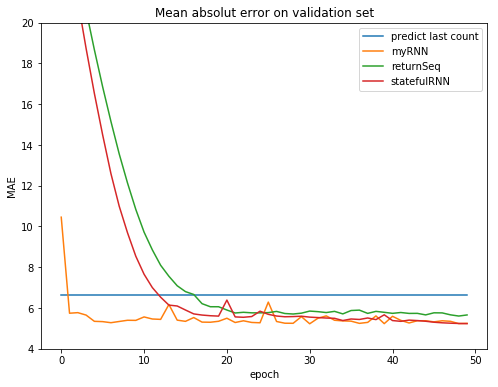

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.repeat(MAE_last_val,50))
plt.plot(myRNN_hist.history['val_mean_absolute_error'])
plt.plot(seqRNN_hist.history['val_mean_absolute_error'])
plt.plot(stateful_val_mae)

plt.title('Mean absolut error on validation set')
plt.ylabel('MAE')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([4,20])
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)

plt.legend(['predict last count', 'myRNN', 'returnSeq', 'statefulRNN'], loc='upper right')
plt.plot()
plt.show()

The first thing to notice is, that `myRRN` converges clearly faster than the two other models. It reaches already after the first epoch an MAE around six. This makes sense because the size of the training set was ten times bigger. However the `seqRNN` has not converged after ten epochs. So basically we make up for the reduced redundancy in the new data format by training for more epochs. 
All models perform better than the naive benchmark of 6.65. However, the improvment seems moderate given the additional model complexity. `seqRNN` and `statefulRNN` seem to converge against a value above five, while `seqRNN` only reaches a value close to six. The higher value of `statefulRNN` was expected due to the missing information at the start of the sample sequences. The stateful property could reduce the MAE back to the level of `myRNN` but it does not clearly improve it. Due to this result and the additional restrictions when building a stateful model we continue to work with the "stateless" variant and the first data format.<br>
So far we have been using a relativ small `SEQ_LEN` of ten. A simpler way of providing more information on past observations than the stateful option would be to increase the sample sequence length. We have not considered that so far because simple RNNs are hard to train on long sequences. The reason for this is the vanishing gradient problem.